In [ ]:
import pandas as pd
df=pd.read_csv("Combined Data.csv")
df.info()
df['status'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Example labels
labels = ['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Convert to dictionary format (for scikit-learn or TensorFlow)
class_weights_dict = dict(zip(np.unique(labels), class_weights))
print(class_weights_dict)

{np.str_('Anxiety'): np.float64(1.0), np.str_('Bipolar'): np.float64(1.0), np.str_('Depression'): np.float64(1.0), np.str_('Normal'): np.float64(1.0), np.str_('Personality disorder'): np.float64(1.0), np.str_('Stress'): np.float64(1.0), np.str_('Suicidal'): np.float64(1.0)}


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Drop rows with missing text
df = df.dropna(subset=['statement'])

# Map labels to integers
label_map = {
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
    'Anxiety': 3,
    'Bipolar': 4,
    'Stress': 5,
    'Personality disorder': 6
}
df['label'] = df['status'].map(label_map)

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

<ipython-input-43-6d35c4787df0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['status'].map(label_map)


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def tokenize_data(df):
    return tokenizer(
        df['statement'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,  # Adjust based on your text length
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)

In [ ]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#datasets
train_dataset = SentimentDataset(train_encodings, train_df['label'].tolist())
val_dataset = SentimentDataset(val_encodings, val_df['label'].tolist())

In [ ]:
from transformers import BertForSequenceClassification, AutoConfig

# Create custom configuration
config = AutoConfig.from_pretrained('bert-base-uncased')
config.num_labels = len(label_map)
config.hidden_dropout_prob = 0.3    # Increased dropout (default is usually 0.1)
config.attention_probs_dropout_prob = 0.3
config.num_hidden_layers = 8        # Reduced from default 12
config.layer_norm_eps = 1e-7        # Slightly stricter normalization
config.output_attentions = True     # Enable attention outputs for monitoring

# Initialize the model with custom config
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=config
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torch import nn

#training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    eval_strategy="epoch",           # Evaluate every epoch
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=6,              # Number of epochs
    weight_decay=0.01,               # Weight decay
    save_strategy="epoch",           # Save model every epoch
    logging_dir='./logs',            # Directory for logs
    logging_steps=10,                # Log every 10 steps
    report_to="none",                # Disable wandb and other logging integrations
    disable_tqdm=False,              # Ensure tqdm progress bars are enabled (default)
    fp16=True,                       # Enable mixed precision training (optional)
)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Custom Trainer with weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Get the device of the model
        if isinstance(model, torch.nn.DataParallel):
            device = model.module.device  # Access the underlying model's device
        else:
            device = model.device  # Single-GPU case

        # Move inputs to the correct device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Move class weights to the correct device
        class_weights_device = class_weights.to(device)

        # Get labels and outputs
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        # Compute loss with class weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Initialize the Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

<ipython-input-45-3c0a057fe71d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.521000,0.651001
2,0.584400,0.584917
3,0.333800,0.560182
4,0.338200,0.572299
5,0.367600,0.589390
6,0.219700,0.605158


<ipython-input-45-3c0a057fe71d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-45-3c0a057fe71d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-45-3c0a057fe71d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-45-3c0a057fe71d>:9: UserWarning: To copy construct from a 

TrainOutput(global_step=15804, training_loss=0.5476155952844883, metrics={'train_runtime': 1839.879, 'train_samples_per_second': 137.435, 'train_steps_per_second': 8.59, 'total_flos': 1.1127728904781824e+16, 'train_loss': 0.5476155952844883, 'epoch': 6.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

<ipython-input-45-3c0a057fe71d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.605157732963562, 'eval_runtime': 14.9491, 'eval_samples_per_second': 704.857, 'eval_steps_per_second': 44.083, 'epoch': 6.0}


In [ ]:
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json')

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import pandas as pd
import torch.nn.functional as F

def load_model_and_tokenizer(model_path):
    """Load the saved model and tokenizer"""
    model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    return model, tokenizer

def predict_mental_health(text, model, tokenizer):
    """Make prediction for a single text input"""
    # Prepare the text
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = F.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()

    return predicted_class, probabilities[0]

def get_label_name(label_id):
    """Convert numerical label to string"""
    label_map = {
        0: 'Normal',
        1: 'Depression',
        2: 'Suicidal',
        3: 'Anxiety',
        4: 'Bipolar',
        5: 'Stress',
        6: 'Personality disorder'
    }
    return label_map.get(label_id, 'Unknown')

# Load model and tokenizer
print("Loading model and tokenizer...")
model, tokenizer = load_model_and_tokenizer('./fine-tuned-bert')
print("Model and tokenizer loaded successfully!")

Loading model and tokenizer...
Model and tokenizer loaded successfully!


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to predict on a batch of validation data and return the true labels and predicted labels
def predict_on_validation(model, val_dataset, batch_size=16):
    model.eval()
    all_preds = []
    all_labels = []

    # Create a DataLoader for the validation dataset
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    # Disable gradient computation during inference
    with torch.no_grad():
        for batch in val_loader:
            # Move input tensors to the correct device (GPU or CPU)
            inputs = {key: val.to(model.device) for key, val in batch.items()}
            labels = inputs['labels']

            # Get model predictions
            outputs = model(**inputs)
            logits = outputs.logits

            # Get predicted class
            preds = torch.argmax(logits, dim=-1)

            # Collect the predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Get true labels and predicted labels on the validation set
true_labels, predicted_labels = predict_on_validation(model, val_dataset)

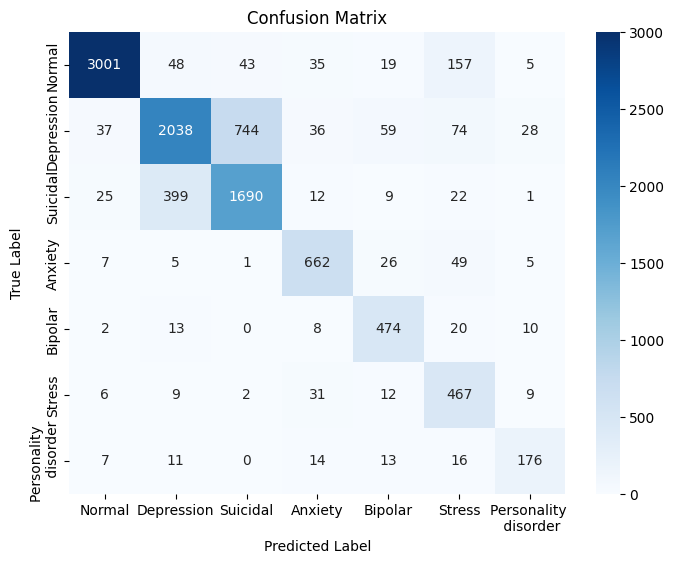

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

label_map = ['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality \n disorder']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map, yticklabels=label_map)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 80.74%


In [ ]:
test_sentences = [
    {
        "text": "I feel fantastic today!",
        "expected": "Normal"
    },
    {
        "text": "I'm struggling with anxiety and depression.",
        "expected": "Depression"
    },
    {
        "text": "Life is going well, and I'm feeling positive.",
        "expected": "Normal"
    },
    {
        "text": "I'm overwhelmed and don't know how to cope.",
        "expected": "Stress"
    },
    {
        "text": "Everything seems so hopeless right now.",
        "expected": "Depression"
    },
    {
        "text": "Work is overwhelming me. I can't sleep and my mind won't stop racing.",
        "expected": "Stress"
    },
    {
        "text": "Nobody understands me. My emotions are intense and I push everyone away.",
        "expected": "Personality disorder"
    },
    {
        "text": "Just finished a yoga session and feeling very peaceful and centered.",
        "expected": "Normal"
    },
    {
        "text": "My thoughts are spiraling and I can't focus on anything. Everything feels threatening.",
        "expected": "Anxiety"
    },
    {
        "text": "I feel empty inside. Nothing matters anymore.",
        "expected": "Depression"
    }
]

In [ ]:
print("\nAnalyzing sentences...\n")
print("=" * 100)
print(f"{'Text':<60} {'Expected':<15} {'Predicted':<15} {'Confidence'}")
print("=" * 100)

for test_case in test_sentences:
    text = test_case["text"]
    expected = test_case["expected"]

    # Get prediction
    predicted_class, probabilities = predict_mental_health(text, model, tokenizer)
    predicted_label = get_label_name(predicted_class)
    confidence = probabilities[predicted_class].item() * 100

    # Print results with truncated text if too long
    truncated_text = text[:57] + "..." if len(text) > 60 else text.ljust(60)
    print(f"{truncated_text} {expected:<15} {predicted_label:<15} {confidence:.1f}%")

print("=" * 100)

# Print detailed analysis of a few examples with high confidence
print("\nDetailed Analysis of High Confidence Predictions:")
print("-" * 50)

for test_case in test_sentences[:3]:  # Analyze first 3 cases
    text = test_case["text"]
    predicted_class, probabilities = predict_mental_health(text, model, tokenizer)

    print(f"\nText: {text}")
    print("Probability Distribution:")
    for i, prob in enumerate(probabilities):
        label = get_label_name(i)
        probability = prob.item() * 100
        print(f"{label:<20}: {probability:.1f}%")
    print("-" * 50)


Analyzing sentences...

Text                                                         Expected        Predicted       Confidence
I feel fantastic today!                                      Normal          Normal          99.7%
I'm struggling with anxiety and depression.                  Depression      Anxiety         98.9%
Life is going well, and I'm feeling positive.                Normal          Normal          97.5%
I'm overwhelmed and don't know how to cope.                  Stress          Normal          82.5%
Everything seems so hopeless right now.                      Depression      Suicidal        45.2%
Work is overwhelming me. I can't sleep and my mind won't ... Stress          Stress          83.5%
Nobody understands me. My emotions are intense and I push... Personality disorder Depression      75.9%
Just finished a yoga session and feeling very peaceful an... Normal          Normal          97.5%
My thoughts are spiraling and I can't focus on anything. ... Anxiety      